In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mnist import MNIST
from display_network import *

Load data

In [2]:
mnist_train = MNIST('../MNIST/')
mnist_train.load_training()
X_train_all = np.asarray(mnist_train.train_images)
y_train_all = np.array(mnist_train.train_labels.tolist())

mnist_test = MNIST('../MNIST/')
mnist_test.load_testing()
X_test_all = np.asarray(mnist_test.test_images)
y_test_all = np.asarray(mnist_test.test_labels.tolist())

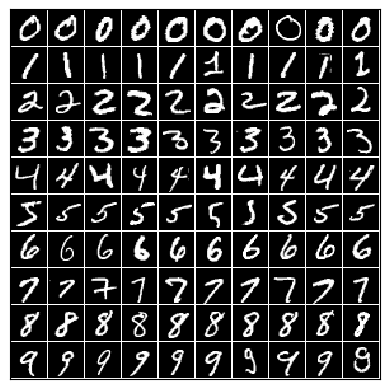

In [3]:
digits = np.arange(10)
A = np.empty((0, X_train_all.shape[1]))
for digit in digits:
    digit_ids = X_train_all[np.where(y_train_all == digit)[0],:]
    A = np.concatenate([A, digit_ids[:10, :]], axis = 0)
    
image = display_network(A.T, m = 10, n = 10)
fig = plt.imshow(image, interpolation = 'nearest', cmap = 'gray')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.show()

In [4]:
cls = [[0], [1]]

def extract_data(X, y, classes):
    """
    X: numpy array, matrix of size (N, d), d is data dim
    y: numpy array, size (N, )
    cls: two lists of labels. For example: 
        cls = [[1, 4, 7], [5, 6, 8]]
    return:
        X: extracted data
        y: extracted label 
            (0 and 1, corresponding to two lists in cls)
    """
    y_res_id = np.array([])
    for color in classes[0]:
        y_res_id = np.hstack((y_res_id, np.where(y == color)[0]))
    N0 = len(y_res_id)
    
    for color in classes[1]:
        y_res_id = np.hstack((y_res_id, np.where(y == color)[0]))
    N1 = len(y_res_id) - N0
    
    y_res_id = y_res_id.astype(int)
    X_res = X[y_res_id, :]/255.0
    y_res = np.asarray([0]*N0 + [1]*N1)
    return (X_res, y_res)

(X, y) = extract_data(X_train_all, y_train_all, cls)

(X_test, y_test) = extract_data(X_test_all, y_test_all, cls)

Data Preprocessing

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

# Bias trick
X_train = np.concatenate([np.ones((X_train.shape[0], 1), dtype = int), X_train], axis = 1)
X_val = np.concatenate([np.ones((X_val.shape[0], 1), dtype = int), X_val], axis = 1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1), dtype = int), X_test], axis = 1)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (10132, 785)
Shape of X_val: (2533, 785)
Shape of y_train: (10132, 1)
Shape of y_val: (2533, 1)


Logistic Regression

In [11]:
class LogisticRegression():
    def __init__(self, C : float = 1.0):
        self.lamda = 1/C  # weight-decay regularization
    
    def sigmoid(self, s : np.ndarray) -> np.ndarray:
        s = np.clip(s, -500, 500)   # avoid overflow when inplement exponential np.exp()
        return 1/(1 + np.exp(-s))

    def has_converged(self, w : np.ndarray, epsilon = 1e-5) -> bool:
        return (np.linalg.norm(w)/len(w) < epsilon)

    def loss_function(self, X : np.ndarray, y : np.ndarray, w : np.ndarray, epsilon = 1e-10) -> float:
        z = self.sigmoid(X @ w)
        return -np.mean(y*np.log(z + epsilon) + (1 - y)*np.log(1 - z + epsilon)) + 0.5*self.lamda*(w.T @ w)   # adding epsilon to avoid log(z) with z ~ 0 --> log(z) ~ -inf
    
    def fit(self, X_train : np.ndarray, y_train : np.ndarray, eta = 0.05, gamma = 0.9, n_epochs = 1000):
        (N, d) = X_train.shape
        w = [np.random.rand(d,1)]
        w_toCheck = w[-1]
        v = [np.zeros_like(w[-1])]
        loss_val = [self.loss_function(X_train, y_train, w[-1])]
        
        epochs, count, iter_check = n_epochs, 0, 10
        # Training model with NAG and using L2 regularization to avoid overfitting
        for epoch in range(epochs):
            count += 1
            gradient = (X_train.T @ (self.sigmoid(X_train @ (w[-1] - gamma*v[-1])) - y_train) + self.lamda*w[-1])
            v_next = gamma*v[-1] + eta*gradient
            w_next = w[-1] - v_next
            w.append(w_next)
            loss_val.append(self.loss_function(X_train, y_train, w[-1]))
            if not (count % iter_check):
                if (self.has_converged(w_next - w_toCheck)):
                    self.w = w[-1]
                    self.epoch = epoch
                    self.loss_val = loss_val[-1]
                    return v, w, epoch, loss_val
                w_toCheck = w[-1]
        
        self.w = w[-1]
        self.epoch = epoch
        self.loss_val = loss_val[-1]
        return v, w, epoch, loss_val
    
    def predict(self, X : np.ndarray, threshold = 0.5) -> np.ndarray:
        res = np.zeros(X.shape[0], dtype = int)
        res[np.where(self.sigmoid(X @ self.w) > threshold)[0]] = 1
        return res.reshape(-1, 1)

Predict and Evaluate

In [13]:
def accuracy_score(y_test : np.ndarray, y_pred : np.ndarray) -> float:
    return np.mean(y_test == y_pred)

logreg = LogisticRegression(C = 1e10)
logreg.fit(X_train, y_train)
print(f"Loss value: {logreg.loss_val}")
print(f"Epochs: {logreg.epoch + 1}")

print(f"Accuracy score of Validation Set: {accuracy_score(y_val, logreg.predict(X_val)) * 100} % ")
print(f"Accuracy score of Test Set: {accuracy_score(y_test, logreg.predict(X_test)) * 100} % ")

Loss value: [[0.01379054]]
Epochs: 1000
Accuracy score of Validation Set: 99.8026056060008 % 
Accuracy score of Test Set: 99.90543735224587 % 


In [8]:
"""
Chú ý lỗi sai:
Khi so sánh hai object trong hàm accuracy_score phải chú ý
các object phải có cùng kích thước (shape), kiểu dữ liệu.
Dưới đây là một ví dụ khi so sánh hai object không cùng kích thước
"""
I = np.array([[1],
              [2],
              [3],
              [4]])
J = np.array([1, 2, 3, 4])

print(I == J)
print(f"Accuracy score: {accuracy_score(I, J) * 100} %")

[[ True False False False]
 [False  True False False]
 [False False  True False]
 [False False False  True]]
Accuracy score: 25.0 %
